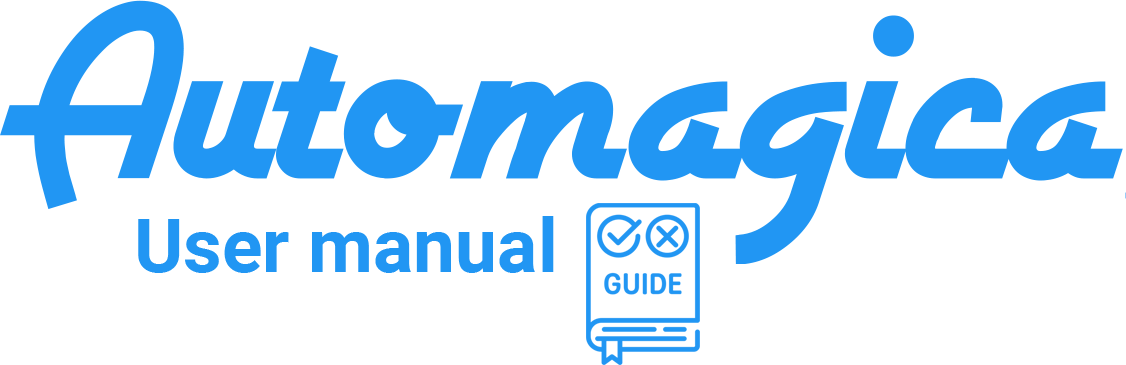

# FTP

The File Transfer Protocol (FTP) is a standard network protocol used for the transfer of computer files between a client and server on a computer network. With these activities you can automate FTP interactions very easily

## Setting up a demo FTP

For development and testing it can be useful to set up an FTP test environment. This can be done very quickly in Windows, if you have an English OS you can even use the steps down below to automatically set up an environment with a little help of Automagica 

In [21]:
def activity(func):
    """Wrapper for Automagica activities
    """
    from functools import wraps
    import logging

    @wraps(func)
    def wrapper(*args, **kwargs):
        if func.__doc__:
            name = func.__doc__.split("\n")[0]
        else:
            name = func.__name__
        logging.info("Automagica (activity): {}".format(name))
        telemetry(func)
        return func(*args, **kwargs)

    return wrapper


def telemetry(func):
    """Automagica Activity Telemetry
    This allows us to collect information on the usage of 
    certain Automagica functionalities in order for us to keep improving 
    the software. If you would like to disable telemetry, make sure the 
    environment variable 'AUTOMAGICA_NO_TELEMETRY' is set. That way no
    information is being shared with us.
    """
    import requests
    from uuid import getnode
    import os
    import platform

    if not os.environ.get("AUTOMAGICA_NO_TELEMETRY") and not os.environ.get(
        "AUTOMAGICA_URL"
    ):
        if func.__doc__:
            name = func.__doc__.split("\n")[0]
        else:
            name = func.__name__

        data = {
            "activity": name,
            "machine_id": getnode(),
            "os": {
                "name": os.name,
                "platform": platform.system(),
                "release": platform.release(),
            },
        }

        try:
            r = requests.post(
                "https://telemetry.automagica.io/api", json=data, timeout=1
            )
        except:
            pass


"""
Text-to-speech (TTS)
"""


@activity
def speak(text, speed=None):
    """Speak
    Use the Text-To-Speech engine available on your system

    :param text: The text which should be said
    :param speed: Multiplication factor for the speed at which the text should be pronounced. 
    """
    import pyttsx3

    engine = pyttsx3.init()

    if speed:
        default_rate = engine.getProperty("rate")
        engine.setProperty("rate", speed * default_rate)

    engine.say(text)
    engine.runAndWait()


"""
Active Directory
"""


class ActiveDirectory:
    def __init__(self, ldap_server=None, username=None, password=None):
        import pyad

        self.pyad = pyad
        
        if ldap_server:
            self.pyad.set_defaults(ldap_server=ldap_server)

        if username:
            self.pyad.set_defaults(username=username)

        if password:
            self.pyad.set_defaults(password=password)
    @activity
    def get_object_by_distinguished_name(self, distinguished_name):
        return self.pyad.from_dn(distinguished_name)


"""
Cryptography
"""

@activity
def generate_random_key():
    """Generates a random Fernet key. 

    Fernet guarantees that a message encrypted using it cannot be manipulated or read without the key. Fernet is an implementation of symmetric (also known as “secret key”) authenticated cryptography
    """
    import os
    from cryptography.fernet import Fernet
    key = Fernet.generate_key()

    return key

@activity
def encrypt_text_with_key(text, key):
    """Encrypts string with (Fernet) key, returns bytes-like object.

    :param text: Text to be encrypted.
    :param path: Path where key is stored.
    """
    from cryptography.fernet import Fernet
    f = Fernet(key)

    return f.encrypt(text.encode('utf-8'))

@activity
def decrypt_text_with_key(encrypted_text, key):
    """Decrypts bytes-like object to string with (Fernet) key
    
    :param encrypted_text: Text to be encrypted.
    :param path: Path where key is stored.
    """
    from cryptography.fernet import Fernet
    f = Fernet(key)

    return f.decrypt(encrypted_text).decode("utf-8") 

@activity
def encrypt_file_with_key(input_file, output_file, key):
    """Encrypts file with (Fernet) key
    
    :param input_file: File to be encrypted.
    :param output_file: Outputfile, returns a bytes-like can be an arbitrary .
    """
    from cryptography.fernet import Fernet

    with open(input_file, 'rb') as f:
        data = f.read()

    fernet = Fernet(key)
    encrypted = fernet.encrypt(data)

    with open(output_file, 'wb') as f:
        f.write(encrypted)

@activity
def decrypt_file_with_key(input_file, output_file, key):
    """Decrypts file with (Fernet) key
    
    :param input_file: Bytes-like file to be decrypted.
    :param output_file: Outputfile, make sure to give this the same extension as basefile before encryption.
    """
    from cryptography.fernet import Fernet

    with open(input_file, 'rb') as f:
        data = f.read()

    fernet = Fernet(key)
    encrypted = fernet.decrypt(data)

    with open(output_file, 'wb') as f:
        f.write(encrypted)

@activity
def generate_key_from_password(password, salt=None):
    """Generates (Fernet) key based on password and salt.
    
    :param text: text to be encrypted.
    :param salt: Salt to generate key in combination with password. Default value is the hostname. Take in to account that hostname is necessary to generate key, e.g. when files are encrypted with salt 'A' and password 'B', both elements are necessary to decrypt files.
    """
    import base64
    from cryptography.hazmat.backends import default_backend
    from cryptography.hazmat.primitives import hashes
    from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
    import socket

    # If no salt is set, use hostname as salt
    if not salt:
        salt = socket.gethostname().encode('utf-8')
    
    kdf = PBKDF2HMAC(algorithm=hashes.SHA256(),length=32,salt=salt,iterations=500000,backend=default_backend())
    key = base64.urlsafe_b64encode(kdf.derive(password.encode('utf-8'))) 
    
    return key

@activity
def generate_hash_from_file(file, method='md5', buffer_size = 65536):
    """Generate hash from file. Can be used to create unique identifier for file validation or comparison.

    :param file: File to hash
    :param method: Method for hashing, choose between 'md5', 'sha256' and 'blake2b'. Note that different methods generate different hashes.
    :param buffer_size: Buffer size for reading file in chunks, default value is 64kb
    """
    import sys
    import hashlib

    # Arbitrary buffer size. 64kb for compatibility with most systems
    buffer_size = 65536  

    if method == 'md5':
        hash_list = hashlib.md5()
    if method == 'sha256':
        hash_list = hashlib.sha1()
    if method == 'blake2b':
        hash_list = hashlib.blake2b()

    with open(file, 'rb') as f:
        while True:
            data = f.read(buffer_size)
            if data:
                hash_list.update(data)
            else:
                return hash_list.hexdigest()

@activity			
def generate_hash_from_text(text, method='md5'):
    """Generate hash from text.
    
    :param file: Text to hash
    :param method: Method for hashing, choose between 'md5', 'sha256' and 'blake2b'. Note that different methods generate different hashes.
    """
    import sys
    import hashlib

    encoded_text = text.encode('utf-8')

    if method == 'md5':
        return hashlib.md5(encoded_text).hexdigest()
    if method == 'sha256':
        return hashlib.sha256(encoded_text).hexdigest()
    if method == 'blake2b':
        return hashlib.balke2b(encoded_text).hexdigest()

"""
Random
"""

@activity
def generate_random_name(locale=None):
    """Generates a random name.

    :param locale: Add a locale to generate popular name for selected locale.
        ar_EG - Arabic (Egypt)
        ar_PS - Arabic (Palestine)
        ar_SA - Arabic (Saudi Arabia)
        bg_BG - Bulgarian
        bs_BA - Bosnian
        cs_CZ - Czech
        de_DE - German
        dk_DK - Danish
        el_GR - Greek
        en_AU - English (Australia)
        en_CA - English (Canada)
        en_GB - English (Great Britain)
        en_NZ - English (New Zealand)
        en_US - English (United States)
        es_ES - Spanish (Spain)
        es_MX - Spanish (Mexico)
        et_EE - Estonian
        fa_IR - Persian (Iran)
        fi_FI - Finnish
        fr_FR - French
        hi_IN - Hindi
        hr_HR - Croatian
        hu_HU - Hungarian
        hy_AM - Armenian
        it_IT - Italian
        ja_JP - Japanese
        ka_GE - Georgian (Georgia)
        ko_KR - Korean
        lt_LT - Lithuanian
        lv_LV - Latvian
        ne_NP - Nepali
        nl_NL - Dutch (Netherlands)
        no_NO - Norwegian
        pl_PL - Polish
        pt_BR - Portuguese (Brazil)
        pt_PT - Portuguese (Portugal)
        ro_RO - Romanian
        ru_RU - Russian
        sl_SI - Slovene
        sv_SE - Swedish
        tr_TR - Turkish
        uk_UA - Ukrainian
        zh_CN - Chinese (China)
        zh_TW - Chinese (Taiwan)
    """
    from faker import Faker
    if locale:
        seed = Faker(locale)
    else:
        seed = Faker()
    return seed.name()

def generate_random_sentence(locale=None):
    """Generates a random sentence.

    :param locale: Add a locale to generate sentences for selected locale (language).
        ar_EG - Arabic (Egypt)
        ar_PS - Arabic (Palestine)
        ar_SA - Arabic (Saudi Arabia)
        bg_BG - Bulgarian
        bs_BA - Bosnian
        cs_CZ - Czech
        de_DE - German
        dk_DK - Danish
        el_GR - Greek
        en_AU - English (Australia)
        en_CA - English (Canada)
        en_GB - English (Great Britain)
        en_NZ - English (New Zealand)
        en_US - English (United States)
        es_ES - Spanish (Spain)
        es_MX - Spanish (Mexico)
        et_EE - Estonian
        fa_IR - Persian (Iran)
        fi_FI - Finnish
        fr_FR - French
        hi_IN - Hindi
        hr_HR - Croatian
        hu_HU - Hungarian
        hy_AM - Armenian
        it_IT - Italian
        ja_JP - Japanese
        ka_GE - Georgian (Georgia)
        ko_KR - Korean
        lt_LT - Lithuanian
        lv_LV - Latvian
        ne_NP - Nepali
        nl_NL - Dutch (Netherlands)
        no_NO - Norwegian
        pl_PL - Polish
        pt_BR - Portuguese (Brazil)
        pt_PT - Portuguese (Portugal)
        ro_RO - Romanian
        ru_RU - Russian
        sl_SI - Slovene
        sv_SE - Swedish
        tr_TR - Turkish
        uk_UA - Ukrainian
        zh_CN - Chinese (China)
        zh_TW - Chinese (Taiwan)
    """
    from faker import Faker
    if locale:
        seed = Faker(locale)
    else:
        seed = Faker()
    return seed.sentence()

@activity
def generate_random_address(locale=None):
    """Generates a random address.

    :param locale: Add a locale to generate addresses for selected locale.
        ar_EG - Arabic (Egypt)
        ar_PS - Arabic (Palestine)
        ar_SA - Arabic (Saudi Arabia)
        bg_BG - Bulgarian
        bs_BA - Bosnian
        cs_CZ - Czech
        de_DE - German
        dk_DK - Danish
        el_GR - Greek
        en_AU - English (Australia)
        en_CA - English (Canada)
        en_GB - English (Great Britain)
        en_NZ - English (New Zealand)
        en_US - English (United States)
        es_ES - Spanish (Spain)
        es_MX - Spanish (Mexico)
        et_EE - Estonian
        fa_IR - Persian (Iran)
        fi_FI - Finnish
        fr_FR - French
        hi_IN - Hindi
        hr_HR - Croatian
        hu_HU - Hungarian
        hy_AM - Armenian
        it_IT - Italian
        ja_JP - Japanese
        ka_GE - Georgian (Georgia)
        ko_KR - Korean
        lt_LT - Lithuanian
        lv_LV - Latvian
        ne_NP - Nepali
        nl_NL - Dutch (Netherlands)
        no_NO - Norwegian
        pl_PL - Polish
        pt_BR - Portuguese (Brazil)
        pt_PT - Portuguese (Portugal)
        ro_RO - Romanian
        ru_RU - Russian
        sl_SI - Slovene
        sv_SE - Swedish
        tr_TR - Turkish
        uk_UA - Ukrainian
        zh_CN - Chinese (China)
        zh_TW - Chinese (Taiwan)
    """
    from faker import Faker
    if locale:
        seed = Faker(locale)
    else:
        seed = Faker()
    return seed.address()

@activity
def generate_random_number(lower_limit=0,upper_limit=10, fractional=False):
    """Generates a random number. Can be integers (not a fractional number) or a float (fractional number).

    :param lower_limit: Lower limit for random number
    :param upper_limit: Upper limit for random number
    :param fractional: Setting this to True will generate fractional number. Default value is False and only generates whole numbers.
    """
    import random 
    if fractional:
        return random.uniform(lower_limit, upper_limit)
    else:
        return random.randrange(lower_limit,upper_limit,1)

@activity
def generate_random_boolean():
    """Generates a random boolean (True or False)
    """
    import random 
    return bool(random.getrandbits(1))

@activity
def generate_random_beep(max_duration=2000, max_frequency=5000):
    """Generates a random beep, only works on Windows

    :param max_duration: Maximum random duration in miliseconds. Default value is 2 miliseconds
    :param max_frequency: Maximum random frequency in Hz. Default value is 5000 Hz.
    """
    import winsound
    import random
    frequency = random.randrange(5000)
    duration = random.randrange(2000)
    winsound.Beep(frequency, duration)

@activity
def generate_random_date(format='%m/%d/%Y %I:%M', days_in_past=1000):
    """Generate a random date. 

    :param days_in_past: Days in the past for which oldest random date is generated, default is 1000 days
    :param format: Formatting of the dates, replace with 'None' to get raw datetime format. 
    e.g. format='Current month is %B' generates 'Current month is Januari' and format='%m/%d/%Y %I:%M' generates format 01/01/1900 00:00. 
    %a	Abbreviated weekday name.	 
    %A	Full weekday name.	 
    %b	Abbreviated month name.	 
    %B	Full month name.	 
    %c	Predefined date and time representation.	 
    %d	Day of the month as a decimal number [01,31].	 
    %H	Hour (24-hour clock) as a decimal number [00,23].	 
    %I	Hour (12-hour clock) as a decimal number [01,12].	 
    %j	Day of the year as a decimal number [001,366].	 
    %m	Month as a decimal number [01,12].	 
    %M	Minute as a decimal number [00,59].	 
    %p	AM or PM.
    %S	Second as a decimal number [00,61].	
    %U	Week number of the year (Sunday as the first day of the week) as a decimal number [00,53]. All days in a new year preceding the first Sunday are considered to be in week 0.	(3)
    %w	Weekday as a decimal number [0(Sunday),6].	 
    %W	Week number of the year (Monday as the first day of the week) as a decimal number [00,53]. All days in a new year preceding the first Monday are considered to be in week 0.	(3)
    %x	Predefined date representation.	 
    %X	Predefined time representation.	 
    %y	Year without century as a decimal number [00,99].	 
    %Y	Year with century as a decimal number.
    %Z	Time zone name (no characters if no time zone exists).
    """

    import random
    import datetime

    latest  = datetime.datetime.now()
    earliest = latest - datetime.timedelta(days=days_in_past)
    delta_seconds = (latest - earliest).total_seconds()

    random_date = earliest + datetime.timedelta(seconds = random.randrange(delta_seconds))

    if format:
        return random_date.strftime(format)
    else:
        return random_date


@activity
def generate_unique_identifier():
    """Generates a random UUID
    """
    from uuid import uuid4

    return str(uuid4())

@activity
def random_animal_picture(preferred_animal=None):
    """Returns url for a random picture

    Note that this service uses an external database, we can not garantuee the quality and availability. 
    The purpose of this activity is mainly for testing to generate dummy data. Will most likely return a picture of a cat, dog or fox.

    :parameter preferred_animal: Return a preferred animal, if not specified will return what is available at the moment. Options are 'cat', 'dog' or 'fox'.
    """
    import requests
    import random

    api_options = [{'animal' : 'cat', 'url' :'https://aws.random.cat/meow', 'image_tag' : 'file'}, {'animal' : 'dog', 'url' :'https://random.dog/woof.json', 'image_tag' : 'url'}, {'animal' : 'fox', 'url' :'https://randomfox.ca/floof/', 'image_tag' : 'image'}]
    
    if preferred_animal:
        if preferred_animal in ['dog', 'cat', 'fox']:
            option = list(filter(lambda api_option: api_option['animal'] == preferred_animal, api_options))[0]
            response = requests.get(option['url'])
            if response.status_code != 200:
                raise Exception('Could not retreive image from external database')
            return response.json()[option['image_tag']]
    
    random.shuffle(api_options)
    for item in api_options:
        response = requests.get(item['url'])
        if response.status_code != 200:
            continue
        else:
            return response.json()[item['image_tag']]


"""
Ask user input
"""

@activity
def ask_user_input(title="Title", label="Input", password=False):
    """Ask user for input
    Prompt the user for an input

    :param title: Title for the pop-up window
    :param message: The message to be shown to the user
    """
    import PySimpleGUI as sg

    sg.ChangeLookAndFeel("SystemDefault")

    text = sg.Text(label, background_color="#2196F3", text_color="white")

    input_field = sg.InputText(justification="center", focus=True)

    if password:
        input_field = sg.InputText(
            password_char="*", justification="center", focus=True
        )

    submit_button = sg.Submit(button_color=("white", "#0069C0"))

    layout = [[text], [input_field], [submit_button]]

    window = sg.Window(
        title,
        layout,
        icon="icon.ico",
        no_titlebar=True,
        background_color="#2196F3",
        element_justification="center",
        use_default_focus=False,
    )
    _, values = window.Read()
    window.Close()
    value = values[0]

    return value


@activity
def ask_user_password(label="Password"):
    """Ask user for password
    Prompt the user for a password. The password will be masked on screen while entering.

    :param title: Title for the pop-up window
    :param message: The message to be shown to the user
    """
    return ask_user_input(title="Password", label=label, password=True)


@activity
def ask_credentials(
    title="Credentials required",
    dialogue_text_username="Username:",
    dialogue_text_password="Password:",
):
    """Ask a user for credentials
    Prompt a popup which asks user for username and password and returns in plain text. Password will be masked.

    :param title: Title for the popup
    :param dialogue_text: Dialogue text for username
    :param dialogue_text: Dialogue text for password
    """
    import PySimpleGUI as sg

    sg.ChangeLookAndFeel("SystemDefault")

    layout = [
        [
            sg.Text(
                dialogue_text_username, background_color="#2196F3", text_color="white"
            )
        ],
        [sg.InputText(justification="center", focus=True)],
        [
            sg.Text(
                dialogue_text_password, background_color="#2196F3", text_color="white"
            )
        ],
        [sg.InputText(password_char="*", justification="center")],
        [sg.Submit(button_color=("white", "#0069C0"))],
    ]

    window = sg.Window(
        title,
        layout,
        icon="icon.ico",
        no_titlebar=True,
        background_color="#2196F3",
        element_justification="center",
        use_default_focus=False,
    )
    _, values = window.Read()

    window.Close()
    username = values[0]
    password = values[1]

    return username, password


"""
Browsers
"""


class Chrome:
    def __init__(self, load_images=True, headless=False):
        """Opens the Chrome Browser with the Selenium webdriver.
        Args:
            load_images (bool): do not load images
            headless (bool): run without a window

        Returns:
            webdriver: Selenium Webdriver

        Example:
            browser = ChromeBrowser(ignore_iamges=True)
            browser.get('https://automagica.io')

        """
        import platform
        import os
        from selenium.webdriver import Chrome, ChromeOptions


        # Check what OS we are on
        if platform.system() == "Linux":
            chromedriver_path = "\\bin\\webdriver\\linux64\\chromedriver"
        elif platform.system() == "Windows":
            chromedriver_path = "\\bin\\win32\\chromedriver.exe"
        else:
            chromedriver_path = "\\bin\\mac64\\chromedriver.exe"

        chrome_options = ChromeOptions()

        if headless:
            chrome_options.add_argument("--headless")

        if not load_images:
            prefs = {"profile.managed_default_content_settings.images": 2}
            chrome_options.add_experimental_option("prefs", prefs)

        return Chrome(
            os.path.abspath("") + chromedriver_path, chrome_options=chrome_options
        )

        

    @activity
    def save_all_image(self, target_folder_path=None):
        import requests
        import os
        from urllib.parse import urlparse
        
        images = self.browser.find_elements_by_tag_name('img') 

        for image in images:
            url = image.get_attribute('src')
            a = urlparse(url)
            filename = os.path.basename(a.path)
            
            with open(os.path.join(target_folder_path, filename), 'wb') as f:
                try:
                    r = requests.get(url)
                    f.write(r.content)
                except:
                    pass
                
            


    
    @activity
    def extract_all_text(self):
        return ''



"""
Credentials
"""


@activity
def set_credential(username=None, password=None, system="Automagica"):
    """Add a credential which stores credentials locally. All parameters should be Unicode text. 

    :param username: Username for which credential will be added.
    :param password: Password to add
    :param system: Name of the system for which credentials are stored. Extra safety measure and method for keeping passwords for similar usernames on different applications a part. Highly recommended to change default value.
    """
    import keyring

    keyring.set_password(system, username, password)


@activity
def delete_credential(username=None, password=None, system="Automagica"):
    """Delete a locally stored credential. All parameters should be Unicode text. 

    :param username: Username for which credential (username + password) will be deleted.
    :param system: Name of the system for which password will be deleted. 
    """
    import keyring

    keyring.delete_password(system, username)


@activity
def get_credential(username=None, system="Automagica"):
    """Get a saved credential. All parameters should be Unicode text. 

    :param username: Username to get password for.
    :param system: Name of the system for which credentials are retreived.
    """
    import keyring

    return keyring.get_password(system, username)


"""
Cryptography
"""


@activity
def generate_random_key():
    """
    Generates a random Fernet key. 
    Fernet guarantees that a message encrypted using it cannot be manipulated or read without the key. Fernet is an implementation of symmetric (also known as “secret key”) authenticated cryptography
    """
    import os
    from cryptography.fernet import Fernet

    key = Fernet.generate_key()

    return key


@activity
def encrypt_message_with_key(message, key):
    """
    Encrypts string with (Fernet) key, returns bytes-like object.

    :param message: Message to be encrypted.
    :param path: Path where key is stored.
    """
    from cryptography.fernet import Fernet

    f = Fernet(key)
    return f.encrypt(message.encode("utf-8"))


@activity
def decrypt_message_with_key(encrypted_message, key):
    """
    Decrypts bytes-like object to string with (Fernet) key
    
    :param encrypted_message: Message to be encrypted.
    :param path: Path where key is stored.
    """
    from cryptography.fernet import Fernet

    f = Fernet(key)
    return f.decrypt(encrypted_message).decode("utf-8")


@activity
def encrypt_file_with_key(input_file, output_file, key):
    """
    Encrypts file with (Fernet) key
    
    :param input_file: File to be encrypted.
    :param output_file: Outputfile, returns a bytes-like can be an arbitrary .
    """
    from cryptography.fernet import Fernet

    with open(input_file, "rb") as f:
        data = f.read()

    fernet = Fernet(key)
    encrypted = fernet.encrypt(data)

    with open(output_file, "wb") as f:
        f.write(encrypted)


@activity
def decrypt_file_with_key(input_file, output_file, key):
    """
    Decrypts file with (Fernet) key

    :param input_file: Bytes-like file to be decrypted.
    :param output_file: Outputfile, make sure to give this the same extension as basefile before encryption.
    """
    from cryptography.fernet import Fernet

    with open(input_file, "rb") as f:
        data = f.read()

    fernet = Fernet(key)
    encrypted = fernet.decrypt(data)

    with open(output_file, "wb") as f:
        f.write(encrypted)


@activity
def generate_key_from_password(password, salt=None):
    """
    Encrypts string with (Fernet) key, returns bytes-like object.

    :param message: Message to be encrypted.
    :param path: Path where key is stored.
    """

    import base64
    from cryptography.hazmat.backends import default_backend
    from cryptography.hazmat.primitives import hashes
    from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
    import socket

    # If no salt is set, use hostname as salt
    if not salt:
        salt = socket.gethostname().encode("utf-8")

    kdf = PBKDF2HMAC(
        algorithm=hashes.SHA256(),
        length=32,
        salt=salt,
        iterations=500000,
        backend=default_backend(),
    )
    key = base64.urlsafe_b64encode(kdf.derive(password.encode("utf-8")))

    return key


"""
FTP
"""


class FTP:
    def __init__(self, server, username, password):
        """Create FPT connection

        :param server: Name of the server
        :param username: Username 
        :param password: Password
        """
        import ftplib

        self.connection = ftplib.FTP(server)
        self.connection.login(username, password)

    @activity
    def download_file(self, from_path, to_path=None):
        """Download file from FTP server

        :param from_path: Path to the file on the FPT server to download
        :param to_path: Destination path for downloaded files. Standard is the home directory

        :return: 
        """
        # Set to user home if no path specified
        if not to_path:
            to_path = os.path.expanduser("~")

        self.connection.retrbinary("RETR " + from_path, open(to_path, "wb").write)

    @activity
    def upload_file(self, from_path, to_path=None):
        """Upload file to FTP server

        :param from_path: Path file that will be uploaded
        :param to_path: Destination path for uploade files. Standard is the main directory

        :return: 
        """
        # Set to user home if no path specified
        if not to_path:
            to_path = "/"

        self.connection.retrbinary("RETR " + from_path, open(to_path, "wb").write)

    @activity
    def enumerate_files(self, path="/"):
        """Generate a list of all the files in the FTP directory

        :return: List object
        """
        self.connection.cwd(path)
        lines = self.connection.retrlines("LIST")
        return lines

    @activity
    def directory_exists(self, path):
        """Check if FTP directory exists

        :return: Boolean
        """
        try:
            self.connection.cwd(path)
            return True
        except IOError:
            return False

    @activity
    def create_directory(self, directory_name, path="/"):
        """Create FTP directory
        
        :param directory_name: Name of the new directory, should be a string e.g. 'my_directory'
        """
        self.connection.cwd(path)
        try:
            self.connection.mkd(directory_name)
        except error_perm as e:
            if not e.args[0].startswith("550"):  # Exists already
                raise


"""
Keyboard
"""


@activity
def press_key(key=None):
    """Press and release an entered key.
    """
    from pyautogui import press

    if key:
        return press(key)


@activity
def press_key_combination(first_key, second_key, third_key=None):
    """Press a combination of two or three keys simultaneously.
    """
    from pyautogui import hotkey

    if not third_key:
        return hotkey(first_key, second_key)
    if third_key:
        return hotkey(first_key, second_key, third_key)


@activity
def type_keys(text=None, interval_seconds=0.001):
    """
    Type text in the current active field. The first argument represent the text and is entered as a string. 
    The second variable is the time between two keystrokes. Pay attention that you can only press single 
    character keys. Keys like ":", "F1",... can not be part of the text argument.
    """
    from pyautogui import typewrite
    import platform

    # Set keyboard layout for Windows platform
    if platform.system() == "Windows":
        from win32api import LoadKeyboardLayout

        LoadKeyboardLayout("00000409", 1)
    return typewrite(text, interval=interval_seconds)


"""
Mouse
"""


@activity
def get_mouse_position():
    """
    Displays a message box with the absolute coordinates of the current position of the mouse.
    """
    from pyautogui import position

    coord = position()
    coordstring = "x: " + str(coord[0]) + "\r\ny: " + str(coord[1]) + ""
    return display_message_box(coordstring, "Mouse Position")


@activity
def click(x=None, y=None):
    """
    Clicks on a pixel position on the visible screen determined by x and y coördinates.
    """
    from pyautogui import click

    return click(x, y)


@activity
def double_click(x=None, y=None):
    """
    Double clicks on a pixel position on the visible screen determined by x and y coördinates.
    """
    from pyautogui import doubleClick

    return doubleClick(x, y)


@activity
def right_click(x=None, y=None):
    """
    Right clicks on a pixel position on the visible screen determined by x and y coördinates.
    """
    from pyautogui import rightClick

    return rightClick(x, y)


@activity
def move_mouse_to(x=None, y=None):
    """
    Moves te pointer to a x-y position.
    """
    from pyautogui import moveTo

    return moveTo(x, y)


@activity
def move_mouse_relative(x=None, y=None):
    """
    Moves the mouse an x- and y- distance relative to its current pixel position.
    """
    from pyautogui import moveRel

    return moveRel(x, y)


@activity
def drag_mouse_to(x=None, y=None, button="left"):
    """
    Drag the mouse from its current position to a entered x-y position, while holding a specified button.
    """
    from pyautogui import dragTo

    return dragTo(x, y, 0.2, button=button)


@activity
def click_image(filename=None):
    from pyautogui import locateCenterOnScreen, click

    x, y = locateCenterOnScreen(filename)

    return click(x, y)


@activity
def double_click_image(filename=None):
    from pyautogui import locateCenterOnScreen, click

    x, y = locateCenterOnScreen(filename)

    return click(x, y, 2)


@activity
def right_click_image(filename=None):
    from pyautogui import locateCenterOnScreen, rightClick

    x, y = locateCenterOnScreen(filename)

    return rightClick(x, y)


"""
Folder Operations
"""


@activity
def create_folder(path):
    """
    Creates new folder at the given path
    """
    import os

    if not os.path.exists(path):
        os.makedirs(path)


@activity
def rename_folder(path, new_name):
    """
    Entering "C:\\Users\\OldFolder as old_path" and "NewFolder" as new_folder_name changes
    the name of the directory in C:\\Users from "OldFolder" to "NewFolder".
    """
    import os

    if os.path.exists(path):
        base_path = path.split("\\")[:-1]
        new_path = "\\".join(base_path) + "\\" + new_name
        if not os.path.exists(new_path):
            os.rename(path, new_path)


@activity
def show_folder(path):
    """
    Entering "C:\\Users\\Downloads\\Automagica" will open the folder "Automagica" if the path exists.
    """
    import os

    if os.path.isdir(path):
        os.startfile(path)


@activity
def move_folder(old_path, new_location):
    """
    Entering "C:\\Users\\Oldlocation\\Automagica" as old_path and "C:\\Users\\Newlocation"
    as new_location moves the folder "Automagica" from directory "Oldlocation" to directory "Newlocation".
    If the new location already contains a folder with the same name, a random 8 character uid is added to the name.
    """
    from uuid import uuid4
    import os

    name = old_path.split("\\")[-1]
    new_path = new_location + "\\" + name
    if os.path.isdir(old_path):
        if not os.path.isdir(new_path):
            os.rename(old_path, new_path)
        elif os.path.isdir(new_path):
            new_path = new_path + " (" + str(uuid4())[:8] + ")"
            os.rename(old_path, new_path)


@activity
def remove_folder(path, allow_root=False, delete_read_only=True):
    """
    Entering "C:\\Users\\Documents\\Automagica" removes the folder "Automagica" including all of its subdirectories and files.
    Standard, the safety variable allow_root is False. When False the function checks whether the path lenght has a minimum of 10 characters. 
    This is to prevent entering for example "\\" as a path resulting in deleting the root and all of its subdirectories.
    To turn off this safety check, explicitly set allow_root to True. For the function to work optimal, all files present in the
    directory must be closed.
    """
    import os

    if len(path) > 10 or allow_root:
        if os.path.isdir(path):
            shutil.rmtree(path, ignore_errors=delete_read_only)


@activity
def empty_folder(path, allow_root=False):
    """
    Entering "C:\\Users\\Documents\\Automagica" removes all the files and folders saved in the "Automagica" folder but maintains the folder itself.
    Standard, the safety variable allow_root is False. When False the function checks whether the path lenght has a minimum of 10 characters. 
    This is to prevent entering for example "\\" as a path resulting in deleting the root and all of its subdirectories.
    To turn off this safety check, explicitly set allow_root to True. For the function to work optimal, all files present in the directory
    must be closed.
    """
    import os

    if len(path) > 10 or allow_root:
        if os.path.isdir(path):
            for root, dirs, files in os.walk(path, topdown=False):
                for name in files:
                    os.remove(os.path.join(root, name))
                for name in dirs:
                    os.rmdir(os.path.join(root, name))


@activity
def folder_exists(path):
    """
    This function checks whether the folder with the given path exists, e.g. by entering...
    "C:\\Users\\Documents\\Automagica", the function returns True if the folder exists or False if 
    it doesn't exist.
    """
    import os

    return os.path.isdir(path)


@activity
def copy_folder(old_path, new_location):
    """
    By entering "C:\\Users\\Documents\\Automagica" as old_path and "C:\\Users\\Downloads" as new_location...
    the function copies the folder "Automagica" together with all its contents to the new location. The folder name...
    remains unchanged, except when the folder already exists a 8 character random uid will be added to the name.
    """
    from uuid import uuid4
    import os

    new_path = new_location + "\\" + old_path.split("\\")[-1]
    if os.path.isdir(old_path):
        if not os.path.isdir(new_path):
            shutil.copytree(old_path, new_path)
        elif os.path.isdir(new_path):
            if os.path.isdir(new_path):
                new_path = new_path + " (" + str(uuid4())[:8] + ")"
            shutil.copytree(old_path, new_path)
    return


@activity
def zip_folder(dir_path, new_path):
    """
    Creates a zipped directory of a directory specified by the first argument. The newly zipped directory 
    receives a path specified by the second argument.
    """
    if os.path.isdir(dir_path):
        shutil.make_archive(new_path, "zip", dir_path)
    return


@activity
def unzip(path, new_path=False):
    """
    Unzips a folder specified by the first variable. The unzipped folder will be stored in a directory specified by
    new_path. If this second variable is omitted, the unzipped folder will be stored in the same directory as the 
    zipped folder is located. 
    """
    import zipfile

    if os.path.exists(path):
        zipp = zipfile.ZipFile(path)
        if not new_path:
            base_path = "\\".join(path.split("\\")[:-1])
            zipp.extractall(base_path)
        elif os.path.isdir(new_path):
            zipp.extractall(new_path)
        zipp.close()
    return


@activity
def wait_folder_exists(path):
    """
    Wait until a folder with the entered path exists.
    """
    from time import sleep

    while not os.path.exists(path):
        sleep(1)
    return


"""
Delay
"""


@activity
def wait(seconds=1):
    """Wait for the specified amount of seconds
    """
    from time import sleep

    sleep(seconds)


@activity
def wait_for_image(filename=None, timeout=120):
    """
    Waits for an image to appear on the screen
    """
    from pyautogui import locateCenterOnScreen
    from time import sleep

    for _ in range(timeout):
        try:
            locateCenterOnScreen(filename)
            break
        except TypeError:
            sleep(1)


"""
Microsoft® Office Outlook
"""


class Outlook:
    def __init__(self):
        self.app = self._launch()

    def _launch(self):
        """Utility function to create the Outlook application scope object

        :return: Application object (win32com.client)
        """
        try:
            import win32com.client

            app = win32com.client.Dispatch("outlook.application")

        except:
            raise Exception(
                "Could not launch Outlook, do you have Microsoft Office installed on Windows?"
            )

        return app

    @activity
    def send_email(
        self, to_address, subject, body, html_body=None, attachment_paths=None
    ):
        """Send an e-mail with Outlook.

        :param to_address: The e-mail address the e-mail should be sent to
        :param subject: The subject of the e-mail
        :param body: The text body contents of the e-mail
        :param html_body: The HTML body contents of the e-mail (optional)
        :param attachment_paths: List of file paths to attachments
        """
        # mapi = self.app.GetNamespace("MAPI")

        # Create a new e-mail
        mail = self.app.CreateItem(0)

        mail.To = to_address
        mail.Subject = subject
        mail.Body = body

        if html_body:
            mail.HTMLBody = html_body

        # Add attachments
        if attachment_paths:
            for attachment_path in attachment_paths:
                mail.Attachments.Add(attachment_path)

        # Send the e-mail
        mail.Send()

    @property
    @activity
    def folders(self, limit=100):
        """Retrieve list of folders from Outlook

        :param limit: Maximum number of folders to retrieve
        """

        folders = []

        for i in range(limit):
            try:
                box = self.app.GetNamespace("MAPI").GetDefaultFolder(i)
                name = box.Name
                folders.append(name)
            except:
                pass

        return folders

    @property
    @activity
    def messages(self, folder_name="Inbox", limit=10, fields=None):
        """Retrieve list of messages from Outlook
        
        :param folder_name: Name of the Outlook folder, can be found using :function:`get_folders`.
        :param limit: Number of messages to retrieve

        :return: List of dictionaries containing the e-mail messages with from, to, subject, body and html.
        """

        if not fields:
            fields = ("To", "Subject", "Body", "SentOn")

        messages = []

        # Find the appropriate folder
        for i in range(limit):
            try:
                box = self.app.GetNamespace("MAPI").GetDefaultFolder(i)
                name = box.Name
                if name == folder_name:
                    break
            except:
                pass
        else:
            raise Exception(
                "Could not find the folder with name '{}'.".format(folder_name)
            )

        # Loop over the items in the folder
        for item in box.Items:
            try:
                message = {}

                for key in item._prop_map_get_:
                    if key in fields:
                        message[key] = getattr(item, key)

                messages.append(message)

            except:
                pass

        return messages

    @activity
    def save_attachments(self, folder_name="Inbox", target_folder_path=None):
        """Save all attachments from Outlook

        :param folder_name: Name of the Outlook folder, can be found using :function:`get_folders`.

        :return: List of paths to saved attachments.
        """
        import os

        paths = []

        # Set to user home if no path specified
        if not target_folder_path:
            target_folder_path = os.path.expanduser("~")

        # Find the appropriate folder
        for i in range(999):
            try:
                box = self.app.GetDefaultFolder(i)
                name = box.Name
                if name == folder_name:
                    break
            except:
                pass
        else:
            raise Exception(
                "Could not find the folder with name '{}'.".format(folder_name)
            )

        # Loop over the items in the folder
        for item in box.Items:
            for attachment in item.Attachments:
                path = os.path.join(target_folder_path, attachment.FileName)
                attachment.SaveAsFile(path)
                paths.append(path)

        return paths

    @property
    @activity
    def contacts(self, limit=9999, fields=None):
        """Retrieve list of contacts from Outlook
        
        :return: List of dictionaries containing the e-mail messages with from, to, subject, body and html.
        """
        import win32com.client

        if not fields:
            fields = ("LastName", "FirstName", "Email1Address")

        contacts = []

        mapi = self.app.GetNamespace("MAPI")

        data = mapi.GetDefaultFolder(win32com.client.constants.olFolderContacts)

        for item in data.Items:
            if item.Class == win32com.client.constants.olContact:
                contact = {}
                for key in item._prop_map_get_:
                    if key in fields:
                        if isinstance(getattr(item, key), (int, str)):
                            contact[key] = getattr(item, key)
                contacts.append(contact)

        return contacts

    @property
    @activity
    def add_contact(self, email, first_name="", last_name=""):
        """Create a contact in Outlook

        :param email: The e-mail address for the contact
        :param first_name: First name for the contact (optional)
        :param last_name: Last name for the contact (otpional)
        """

        # Create a new contact
        contact = self.app.CreateItem(2)

        contact.Email1Address = email

        if first_name:
            contact.FirstName = first_name

        if last_name:
            contact.LastName = last_name

        contact.Save()

    @activity
    def quit(self):
        self.app.Application.Quit()


"""
Microsoft® Office Excel
"""


class Excel:
    def __init__(self, visible=True, path=None):
        """Start Excel Application

        For this activity to work, Microsoft Office Excel needs to be installed on the system.

        Thanks to https://pythonexcels.com/python/2009/10/05/python-excel-mini-cookbook for the great examples.

        :parameter visible: Show Excel in the foreground if True or hide if False, defaults to True.
        :parameter path: Enter a path to open Excel with an existing Excel file. If no path is specified a workbook will be initialized, this is the default value.
        """
        self.app = self._launch()
        self.app.Visible = visible

    def _launch(self):
        """Utility function to create the Excel application scope object

        :return: Application object (win32com.client)
        """
        try:
            import win32com.client

            app = win32com.client.gencache.EnsureDispatch("Excel.Application")

        except:
            raise Exception(
                "Could not launch Excel, do you have Microsoft Office installed on Windows?"
            )

        if path:
            return app.Worksbooks.Open(file_path)
        else:
            return app.Workbooks.Add()

    @activity
    def new_workbook(self):
        """New Excel Workbook
        Creates a new workbook and returns the workbook object
        """
        return self.app.Workbooks.Add()

    @activity
    def save_workbook(self, workbook, file_path):
        """Save Excel Workbook

        :parameter workbook: Workbook object which is retrieved with either new_workbook or open_workbook
        :parameter file_path: Save the Excel workbook to this path
        """
        return workbook.SaveAs(file_path)

    @activity
    def quit(self):
        """Close Excel Application
        """
        return self.app.Application.Quit()

    @activity
    def add_worksheet(self, workbook, name=None):
        """Add Excel Worksheet
        Adds a worksheet to a workbook

        :parameter workbook: Workbook object which is retrieved with either new_workbook or open_workbook
        :parmeter name: Give the sheet a name (optional)
        """
        worksheet = workbook.Worksheets.Add()
        if name:
            worksheet.Name = name
        return worksheet

    @activity
    def write_cell(self, worksheet, row, column, value):
        """Write Excel Cell
        """
        worksheet.Cells(row, column).Value = value

    @activity
    def read_cell(self, worksheet, row, column):
        """Read Excel Cell
        """
        return worksheet.Cells(row, column).Value

    @activity
    def write_range(self, worksheet, range_, value):
        """Write Excel Range
        """
        worksheet.Range(range_).Value = value

    @activity
    def read_range(self, worksheet, range_):
        """Read Excel Range
        """
        return worksheet.Range(range_).Value

class PowerPoint:
    def __init__(self, visible=True, path=None, add_slide=True):
        """Start Excel Application

        For this activity to work, PowerPoint needs to be installed on the system.

        :parameter visible: Show PowerPoint in the foreground if True or hide if False, defaults to True.
        :parameter path: Enter a path to open an existing PowerPoint presentation. If no path is specified a new presentation will be initialized, this is the default value.
        :parameter add_slide: Add an initial empty slide when creating new PowerPointfile, this prevents errors since most manipulations require a non-empty presentation. Default value is True
        """
        self.app = self._launch(path)
        self.app.Visible = visible


    def _launch(self, path):
        """Utility function to create the Excel application scope object

        :return: Application object (win32com.client)
        """
        try:
            import win32com.client

            app = win32com.client.gencache.EnsureDispatch("PowerPoint.Application")

        except:
            raise Exception(
                "Could not launch PowerPoint, do you have Microsoft Office installed on Windows?")

        if path:
            return app.Presentations.Open(file_path)
        else:
            return app.Presentations.Add()

    @activity
    def save(self, path=None):
        """Save PowerPoint Slidedeck

        :parameter path: Save the PowerPoint presentation. Default value is the home directory and filename 'presentation.pptx'
        """
        if not path:
            path = os.path.expanduser("~") + '\presentation.pptx'

        return self.app.SaveAs(path)

    @activity
    def quit(self):
        """Close PowerPoint Application
        """
        return self.app.Application.Quit()


    @activity
    def add_slide(self, index=None, type='blank'):
        """Add PowerPoint Slides
        Adds slides to a presentation

        :parameter index: Index where the slide should be inserted. Default value is as final slide.
        :parmeter type: Type of the slide to be added. Supports following types: blank, chart, text, title and picture.
        """
        if type == 'blank':
            type_id = 12
        if type == 'chart':
            type_id = 8
        if type == 'text':
            type_id = 2
        if type == 'title':
            type_id = 1
        if type == 'picture':
            type_id = 36
        
        if not index:
            index = self.app.Slides.Count + 1 

        return self.app.Slides.Add(index,type_id)

    @activity
    def number_of_slides(self):
        """Return the number of slides
        """
        return self.app.Slides.Count

    @activity
    def add_text(self, text, index=None, font_size=48, font_name=None, bold=False, margin_bottom=100, margin_left=100, margin_right=100, margin_top=100):
        """Add text to a slide

        :parameter index: Slide index to add text. If none is specified, a new slide will be added as final slide
        :parmeter text: Text to be added
        :parameter font_size: Fontsize, default value is 48
        :parameter font_name: Fontname, if not specified will take default PowerPoint font
        :parameter bold: Toggle bold with True or False, default value is False
        :parameter margin_bottom: Margin from the bottom in pixels, default value is 100 pixels
        :parameter margin_left: Margin from the left in pixels, default value is 100 pixels
        :parameter margin_right: Margin from the right in pixels, default value is 100 pixels
        :parameter margin_top: Margin from the top in pixels, default value is 100 pixels
        """

        if not index:
            index = self.app.Slides.Count + 1 
            self.app.Slides.Add(index, 12)
        text_box = self.app.Slides(index).Shapes.AddTextbox(1,100, 100,200, 50).TextFrame.TextRange
        text_box.Text = text
        text_box.Font.Size = font_size
        if font_name:
            text_box.Font.Name = font_name
        text_box.Font.Bold = bold

    @activity
    def delete_slide(self,index=None):
        """Delete slide
        
        :parameter index: Slide index to be deleted. If none is specified, last slide will be deleted
        """
        if not index:
            index = self.app.Slides.Count 

        return self.app.Slides(index).Delete()

    @activity
    def replace_text(self, placeholder, value):
        """Replace text slide
        Can be used for example to replace arbitrary placeholder value in a PowerPoint. 
        For example when using template slidedeck, using 'XXXX' as a placeholder, this can be easily be replaced to the name of the audience.. 
        Take note that all strings are case sensitive.
        
        :parameter placeholder: Placeholder value (string) in the Powerpoint, this will be replaced, e.g. 'Company Name'
        :parameter value: Value (string) to replace the placeholder values with. It is recommended to make this unique in your PowerPoint to avoid wrongful replacement, e.g. 'XXXX_placeholder_XXX'
        """
        for slide in self.app.Slides:
            for shape in slide.Shapes:
                shape.TextFrame.TextRange.Text = shape.TextFrame.TextRange.Text.replace(placeholder,value)

    @activity
    def export_to_pdf(self, path=None):
        """Export PowerPoint presentation to PDF file

        :parameter path: Output path where PDF file will be exported to. Default path is home directory with filename 'pdf_export.pdf'.
        """

        if self.app.Slides.Count == 0:
            raise Exception('Please add a slide first bedore exporting the presentation.')

        if not path:
            path = os.path.expanduser("~") + '/pdf_export.pdf'
        
        return  self.app.ExportAsFixedFormat2(path, 2, PrintRange=None)

    @activity
    def export_slides_to_images(self, path=None, type='png'):
        """Export PowerPoint slides to seperate image files

        :parameter path: Output path where image files will be exported to. Default path is home directory.
        :parameter type: Output type of the images, supports 'png' and 'jpg' with 'png' as default value
        """

        if self.app.Slides.Count == 0:
            raise Exception('Please add a slide first bedore exporting the presentation.')

        if not path:
            path = os.path.expanduser("~")

        return self.app.Export(path, 'png')


class ExcelFile:
    pass


"""
E-mail (SMTP)
"""


@activity
def send_mail_smtp(
    smtp_host, smtp_user, smtp_password, to_address, subject="", message="", port=587
):
    """
    This function lets you send emails with an e-mail address. The first and second arguments require the
    mail address and password of your e-mail account. The destination is the receiving mail address. The subject
    and message variables contain respectively the mail subject and the text in the mail. The port variable is standard
    587. In most cases this argument can be ignored, but in some cases it needs to be changed to 465.
    """
    BODY = "\r\n".join(
        [
            "To: %s" % destination,
            "From: %s" % user,
            "Subject: %s" % subject,
            "",
            message,
        ]
    )
    smtpObj = smtplib.SMTP(host, port)
    smtpObj.ehlo()
    smtpObj.starttls()
    smtpObj.login(user, password)
    smtpObj.sendmail(user, destination, BODY)
    smtpObj.quit()


"""
Windows
"""


@activity
def set_user_password(username, password):
    """Sets the password for a Windows user.

    :parameter username: Username
    :parameter password: New password
    """
    from win32com import adsi

    user = adsi.ADsGetObject("WinNT://localhost/%s,user" % username)
    user.SetPassword(password)


@activity
def check_user_password(username, password):
    """Checks a password for a Windows user
    
    :parameter username: Username
    :parameter password: New password

    :return: True if the password is correct
    """
    from win32security import LogonUser
    from win32con import LOGON32_LOGON_INTERACTIVE, LOGON32_PROVIDER_DEFAULT

    try:
        LogonUser(
            username,
            None,
            password,
            LOGON32_LOGON_INTERACTIVE,
            LOGON32_PROVIDER_DEFAULT,
        )
    except:
        return False
    return True


@activity
def is_logged_in():
    """Checks if the current user is logged in and not on the lockscreen. A lot of automations do not work properly when the desktop is locked.

    :return: True if the user is logged in
    """
    import subprocess

    output = subprocess.check_output("TASKLIST")

    if "LogonUI.exe" in str(output):
        return False
    else:
        return True


@activity
def desktop_locked():
    """Checks if the current user is locked out and on the lockscreen. A lot of automations do not work properly when the desktop is locked.

    :return: True when the lockscreen is active
    """
    return not is_logged_in()


@activity
def set_to_clipboard(text):
    """Set any text to the Windows clipboard. 
    Credit to Cees Timmerman (https://stackoverflow.com/questions/579687/how-do-i-copy-a-string-to-the-clipboard-on-windows-using-python)

    :parameter text: Text to put in the clipboard
    """
    import win32clipboard

    win32clipboard.OpenClipboard()
    win32clipboard.EmptyClipboard()
    win32clipboard.SetClipboardText(text, win32clipboard.CF_UNICODETEXT)
    win32clipboard.CloseClipboard()


@activity
def get_from_clipboard():
    """Get the text currently in the Windows clipboard
    Credit to Cees Timmerman (https://stackoverflow.com/questions/579687/how-do-i-copy-a-string-to-the-clipboard-on-windows-using-python)

    :return: Text currently in the clipboard
    """
    import win32clipboard

    win32clipboard.OpenClipboard()
    try:
        data = str(win32clipboard.GetClipboardData(win32clipboard.CF_UNICODETEXT))
        return data

    except Exception as e:
        raise e

    finally:
        win32clipboard.CloseClipboard()


@activity
def clear_clipboard():
    """Empty the clipboard
    """
    from ctypes import windll

    if windll.user32.OpenClipboard(None):
        windll.user32.EmptyClipboard()
        windll.user32.CloseClipboard()
    return


@activity
def run_vbs_script(script_path, parameters=[]):
    """Run a VBScript file

    :parameter script_path: Path to the .vbs-file
    :parameter parameters: Additional arguments to pass to the VBScript
    """
    import subprocess

    subprocess.call(["cscript.exe", script_path] + parameters)


@activity
def beep(frequency=1000, duration=250):
    """
    Makes a beeping sound.
    Choose frequency (Hz) and duration (ms), standard is 1000 Hz and 250 ms.
    """
    import winsound

    winsound.Beep(frequency, duration)


@activity
def run_calculator():
    """
    Open Calculator.
    """
    import subprocess

    subprocess.Popen("calc.exe")


@activity
def run_paint():
    """
    Open MS Paint.
    """
    import subprocess

    subprocess.Popen("mspaint.exe")


@activity
def run_notepad():
    """
    Open Notepad
    """
    import subprocess

    subprocess.Popen("notepad.exe")


@activity
def run_snipping_tool():
    """
    Open Snipping Tool.
    """
    import subprocess

    subprocess.Popen("SnippingTool.exe")


@activity
def run_control_panel():
    """
    Open Windows Control Panel.
    """
    import subprocess

    subprocess.Popen("control.exe")


@activity
def run_clean_manager():
    """
    Open Clean Manager.
    """
    import subprocess

    subprocess.Popen("cleanmgr.exe")


@activity
def run_dialer():
    """
    Open Windows Dialer.
    """
    import subprocess

    subprocess.Popen("dialer.exe")


@activity
def run_volume_mixer():
    """
    Open Windows Volume Mixer.
    """
    import subprocess

    subprocess.Popen("SndVol.exe")


@activity
def run_xps_viewer():
    """
    Open Windows XPS Viewer.
    """
    import subprocess

    subprocess.Popen("xpsrchvw")


"""
Utilities
"""


@activity
def home_path():
    """Returns the current user's home path
    :return: Path to the current user's home folder
    """
    from os.path import expanduser

    return expanduser("~")


@activity
def desktop_path():
    """Returns the current user's desktop path
    :return: Path to the current user's desktop folder
    """
    import os.path

    return os.path.join(os.path.expanduser("~"), "Desktop")

@activity
def set_wallpaper(image_path):
    '''Sets desktop wallpaper

    :parameter image_path: Path to the image. This image will be set as desktop wallpaper
    '''
    import ctypes
    ctypes.windll.user32.SystemParametersInfoW(20, 0, image_path , 0)


@activity
def download_image_from_url(url):
    pass

@activity
def display_message_box(body, title="Message", type="info"):
    """
    Shows a pop-up message with title and body. Three possible types, info, error and warning with the default value info.
    """
    import tkinter
    from tkinter import messagebox

    # hide main window
    root = tkinter.Tk()
    root.withdraw()

    if not body:
        messagebox.showwarning("Warning", "No input for message box")

    if type == "error":
        messagebox.showwarning(title, body)
    if type == "warning":
        messagebox.showwarning(title, body)
    if type == "info":
        messagebox.showinfo(title, body)
    return


@activity
def display_osd_message(message, seconds=5):
    if "DISABLE_AUTOMAGICA_OSD" in globals():
        return

    import tkinter, win32api, win32con, pywintypes
    from win32api import GetSystemMetrics

    screen_width = GetSystemMetrics(0)
    screen_height = GetSystemMetrics(1)

    root = tkinter.Tk()
    label = tkinter.Label(
        text=message, font=("Helvetica", "30"), fg="white", bg="black", borderwidth=10
    )
    label.master.overrideredirect(True)
    label.config(anchor=tkinter.CENTER)
    label.master.geometry(
        "+{}+{}".format(int(screen_width / 2), int(screen_height - 250))
    )
    label.master.lift()
    label.master.wm_attributes("-topmost", True)
    label.master.wm_attributes("-disabled", True)
    label.master.wm_attributes("-transparentcolor", "black")

    hWindow = pywintypes.HANDLE(int(label.master.frame(), 16))

    exStyle = (
        win32con.WS_EX_COMPOSITED
        | win32con.WS_EX_LAYERED
        | win32con.WS_EX_NOACTIVATE
        | win32con.WS_EX_TOPMOST
        | win32con.WS_EX_TRANSPARENT
    )
    win32api.SetWindowLong(hWindow, win32con.GWL_EXSTYLE, exStyle)

    label.after(seconds * 1000, lambda: root.destroy())
    label.pack()
    label.mainloop()


"""
Trello
"""


class TrelloInterface:
    pass

    @activity
    def add_card(
        self,
        title="My card",
        description="My description",
        board_name="My board",
        list_name="My list",
        api_key="",
        api_secret="",
        token="",
        token_secret="any",
    ):
        """
        For this you need a Trello API key, secret and token. 
        Token secret can be any string, but should be altered for security purposes.
        """
        from trello import TrelloClient

        client = TrelloClient(
            api_key=api_key,
            api_secret=api_secret,
            token=token,
            token_secret=token_secret,
        )

        trello_boards = client.list_boards()
        for trello_board in trello_boards:
            if trello_board.name == board_name:
                target_board = trello_board
                break

        trello_lists = target_board.all_lists()
        for trello_list in trello_lists:
            if trello_list.name == list_name:
                target_list = trello_list
                break

        target_list.add_card(title, desc=description)


"""
System
"""


@activity
def rename_file(old_path, new_file_name):
    """
    Entering "C:\\Users\\Documents\\Automagica.docx" as "old_path" and "Automagica123.docx" as new_file_name changes
    the name of the directory in C:\\Users\\Documents from Automagica to Automagica123. The function will not
    rename a file if a file with the desired name already exists in the folder.
    """
    if os.path.isfile(old_path):
        base_path = old_path.split("\\")[:-1]
        new_path = "\\".join(base_path) + "\\" + new_file_name
        if not os.path.exists(new_path):
            os.rename(old_path, new_path)


@activity
def move_file(old_path, new_location):
    """
    Entering "C:\\Users\\Documents\\Automagica.docx" as old_path and "C:\\Users\\Downloads"
    as new_location moves the file Automagica.docx from directory "Documents" to directory "Downloads".
    If the new location already contains a file with the same name, a random 8 character uid will be added 
    in front of the name before the file is moved.
    """
    import uuid

    name = old_path.split("\\")[-1]
    new_path = new_location + "\\" + name
    if os.path.exists(old_path):
        if not os.path.exists(new_path):
            os.rename(old_path, new_path)
        elif os.path.exists(new_path):
            new_path = new_location + "\\" + "(" + str(uuid.uuid4())[:8] + ") " + name
            os.rename(old_path, new_path)
    return


@activity
def remove_file(path):
    """
    Entering "C:\\Users\\Downloads\\Automagica.xlsx" will delete the file named "Automagica.xlsx" at the location specified by
    the given path.
    """
    if os.path.isfile(path):
        os.remove(path)
    return


@activity
def file_exists(path):
    """
    This function checks whether the file with the given path exists, e.g. by entering
    "C:\\Users\\Documents\\Automagica.docx", the function returns True if the file exists or False
    if it doesn't exist.
    """
    return os.path.isfile(path)


@activity
def wait_file_exists(path):
    """
    Wait until a file with the entered path exists.
    """
    from time import sleep

    while not os.path.exists(path):
        sleep(1)
    return


@activity
def write_list_to_file(list_to_write, file):
    """
    Writes a list to a .txt file. Every element of the entered list is written on a new
    line of the text file. The .txt file is entered with a path. If the path does not exist
    yet, the function will create a new .txt file at the specified path and write it. If the 
    path does exist, the function writes the list in the existing file.
    """
    with open(file, "w") as filehandle:
        filehandle.writelines("%s\n" % place for place in list_to_write)
    return


@activity
def read_list_from_file(file):
    """
    This function writes the content of a entered .txt file to a list and returns that list. 
    Every new line from the .txt file becomes a new element of the list. The function will 
    not work if the entered path is not attached to a .txt file.
    """
    written_list = []
    with open(file, "r") as filehandle:
        filecontents = filehandle.readlines()
        for line in filecontents:
            current_place = line[:-1]
            written_list.append(current_place)
    return written_list


@activity
def append_line(text, file_path):
    """Append a text line to a file and creates the file if it does not exist yet.

    :parameter text: The text line to write to the end of the file
    :parameter file_path: Path to the file to write to
    """
    import os

    if not os.path.isfile(file_path):
        with open(file_path, "a"):
            os.utime(file_path, None)

    with open(file_path, "a") as f:
        f.write("\n" + text)


@activity
def copy_file(from_path, to_path):
    """Copy a file from a path to a path. Can be a folder
    """
    import shutil

    shutil.copy(from_path, to_path)


@activity
def create_directory(path):
    pass


@activity
def create_file(path):
    pass


@activity
def delete_file():
    pass


@activity
def wait_for_file_change():
    pass


@activity
def path_exists():
    pass


@activity
def read_text_file():
    pass


@activity
def write_text_file():
    pass


"""
Automagica Portal Reporting
For more information, see https://automagica.io or sign up directly for the Automagica Portal at https://portal.automagica.io.
"""


@activity
def insert_table_header(data):
    """
    Inserts the header of an Automagica Report.
    """
    data_keys = []

    for row in data:
        for key, _ in row.items():
            if key not in data_keys:
                data_keys.append(key)

    header = "|".join(data_keys)

    header_next = "|".join(["---" for key in data_keys])

    print("AUTOMAGICA_MARKDOWN_START: " + str(header) + " :AUTOMAGICA_MARKDOWN_END")
    print(
        "AUTOMAGICA_MARKDOWN_START: " + str(header_next) + " :AUTOMAGICA_MARKDOWN_END"
    )

    return data_keys


@activity
def insert_table_item(item, keys):
    """
    Inserts the header of an Automagica Report.
    """
    print(
        "AUTOMAGICA_MARKDOWN_START: "
        + "|".join([str(item.get(key, "")) for key in keys])
        + " :AUTOMAGICA_MARKDOWN_END"
    )


@activity
def insert_table(data):
    """
    Function to report in the Automagica Portal. Can be used to generate reports, 
    logs and worklists. Only available to users with access to the Portal. 
    This outputs a list of flat dicts to a markdown table with headers to the console.
    """
    keys = insert_table_header(data)

    for item in data:
        insert_table_item(item, keys)


@activity
def insert_title(title="My title", level=1):
    """
    Function to insert a report title in the Automagica Portal.
    This outputs a string as a title to the console.
    """
    print("AUTOMAGICA_MARKDOWN_START: " + "#" * level + " :AUTOMAGICA_MARKDOWN_END")


"""
PDF
"""


@activity
def read_text_from_pdf(file_path):
    """Extracts the text from a PDF

    :param file_path: Path to the PDF (either relative or absolute)
    :return: The text from the PDF
    """
    from PyPDF2 import PdfFileReader

    text = ""

    with open(file_path, "rb") as f:
        reader = PdfFileReader(f)
        for i in range(reader.numPages):
            page = reader.getPage(i)
            text += page.extractText()

    return text


@activity
def join_pdf_files(file_paths, output_path):
    """Merges multiple PDFs into a single file

    :param file_paths: List of paths to PDF files
    """
    from PyPDF2 import PdfFileMerger, PdfFileReader

    merger = PdfFileMerger()
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            merger.append(PdfFileReader(f))

    merger.write(output_path)


@activity
def extract_page_range_from_pdf(file_path, start_page, end_page, output_path):
    """Extracts a particular range of a PDF to a separate file

    :param file_path: Path to the PDF (either relative or absolute)
    :param start_page: Page number to start from, with 0 being the first page
    :param end_page: Page number to end with, with 0 being the first page
    """
    from PyPDF2 import PdfFileWriter, PdfFileReader

    with open(file_path, "rb") as f:
        reader = PdfFileReader(f)
        writer = PdfFileWriter()

        for i in range(start_page, end_page):
            writer.addPage(reader.getPage(i))

        with open(output_path, "wb") as f:
            writer.write(f)


@activity
def extract_images_from_pdf(file_path):
    """Save a specific page from a PDF as an image
    Credits to user Sylvain on Stackoverflow (https://stackoverflow.com/a/34116472)
    """
    from PyPDF2 import PdfFileReader
    from PIL import Image

    with open(file_path, "rb") as f:
        reader = PdfFileReader(f)
        for i in range(reader.getNumPages()):
            page = reader.getPage(i)
            objects = page["/Resources"]["/XObject"].getObject()

            for obj in objects:
                if objects[obj]["/Subtype"] == "/Image":
                    size = (objects[obj]["/Width"], objects[obj]["/Height"])
                    data = objects[obj].getData()

                    if objects[obj]["/ColorSpace"] == "/DeviceRGB":
                        mode = "RGB"
                    else:
                        mode = "P"

                    if objects[obj]["/Filter"] == "/FlateDecode":
                        img = Image.frombytes(mode, size, data)
                        img.save(obj[1:] + ".png")

                    elif objects[obj]["/Filter"] == "/DCTDecode":
                        img = open(obj[1:] + ".jpg", "wb")
                        img.write(data)
                        img.close()

                    elif objects[obj]["/Filter"] == "/JPXDecode":
                        img = open(obj[1:] + ".jp2", "wb")
                        img.write(data)
                        img.close()


@activity
def save_page_from_pdf_as_image(file_path, page_number):
    """
    TODO
    """
    pass


@activity
def apply_text_watermark_to_pdf(file_path, text, font="Helvetica-Bold", size=36):
    """
    TODO
    """
    pass


@activity
def apply_image_watermark_to_pdf(
    folder_path, text="Automagica", watermark_image_path=""
):
    """
    TODO
    Open a directory containing .pdf files. All files in directory will be marked.
    Fill in text if you want to watermark with text.
    Fill in picture_path if you want to watermark with image.
    """
    from reportlab.pdfgen import canvas
    from PyPDF2 import PdfFileWriter, PdfFileReader
    import os

    # picture_path = 'company_logo.png'
    # # Folder in which PDF files will be watermarked. (Could be shared folder)
    # folder_path = './mydir'

    # c = canvas.Canvas('watermark.pdf')

    # # if picture_path:
    # #     c.drawImage(picture_path, 15, 15)

    # if text:
    # 	c.setFontSize(22)
    # 	c.setFont('Helvetica-Bold', 36)
    # 	c.drawString(15, 15,text)

    # c.save()
    # watermark = PdfFileReader(open("watermark.pdf", "rb"))

    # for file in os.listdir(folder_path):
    # 	if file.endswith(".pdf"):

    # # output_file = PdfFileWriter()
    # #input_file = PdfFileReader(open(folder_path + '/'+ file, "rb"))

    # page_count = input_file.getNumPages()

    # for page_number in range(page_count):
    #    input_page = input_file.getPage(page_number)
    #    input_page.mergePage(watermark.getPage(0))
    #    output_file.addPage(input_page)
    # output_path = folder_path + '/'+ file.split('.pdf')[0] + '_watermarked' + '.pdf'

    # with open(output_path, "wb") as outputStream:
    #    output_file.write(outputStream)




"""
System monitoring
"""


@activity
def get_cpu_load(measure_time=1):
    """
    Returns average CPU load for all cores.
    Measures once every second, adjust measure_time (seconds) to get a longer averaged measured time. Standard measure_time is 1 second.
    """
    import psutil

    cpu_measurements = []
    for _ in range(measure_time):
        cpu_measurements.append(psutil.cpu_percent(interval=1))
    return sum(cpu_measurements) / len(cpu_measurements)


@activity
def get_number_of_cpu(logical=True):
    """
    Returns the number of CPU's in the current system. 
    The parameter 'logical' determines if only logical units are added to the count, default value is True.
    """
    import psutil

    return psutil.cpu_count(logical=logical)


@activity
def get_cpu_frequency():
    """
    Returns frequency at which CPU currently operates.
    Also shows minimum and maximum frequency.
    """
    import psutil

    return psutil.cpu_freq()


@activity
def get_cpu_stats():
    """
    Returns CPU statistics: Number of CTX switches, intterupts, soft-interrupts and systemcalls.
    """
    import psutil

    return psutil.cpu_stats()


@activity
def get_memory_stats(mem_type="swap"):
    """
    Returns memory statistics: total, used, free and percentage in use.
    Choose mem_type = 'virtual' for virtual memory, and mem_type = 'swap' for swap memory (standard).
    """
    import psutil

    if mem_type == "virtual":
        return psutil.virtual_memory()
    else:
        return psutil.swap_memory()


@activity
def get_disk_stats():
    """
    Returns disk statistics of main disk: total, used, free and percentage in use.
    """
    import psutil

    return psutil.disk_usage("/")


@activity
def get_disk_partitions():
    """
    Returns tuple with info for every partition.
    """
    import psutil

    return psutil.disk_partitions()


@activity
def get_boot_time():
    """
    Returns time PC was booted in seconds after the epoch.
    """
    import psutil

    return psutil.boot_time()


@activity
def get_time_since_last_boot():
    """
    Returns time since last boot in seconds.
    """
    import time
    import psutil

    return time.time() - psutil.boot_time()


"""
Image operations
"""

@activity
def download_image_from_url():
    """
    TODO
    """
    return


@activity
def show_image(path):
    """
    Displays an image specified by the path variable on the default imaging program.
    """
    from PIL import Image

    im = Image.open(path)

    return im.show()


@activity
def rotate_image(path, angle=90):
    """
    Entering "C:\\Users\\Pictures\\Automagica.jpg" as path and an a angle of 90 rotates the picture specified by the first
    argument over 90 degrees. Pay attention, because angles other than 90, 180, 270, 360 can resize the picture. 
    """
    from PIL import Image

    im = Image.open(path)

    return im.rotate(angle, expand=True).save(path)


@activity
def resize_image(path, size):
    """
    Resizes the image specified by the path variable. The size is specifie by the second argument. This is a tuple with the
    width and height in pixels. E.g. ResizeImage("C:\\Users\\Pictures\\Automagica.jpg", (300, 400)) gives the image a width
    of 300 pixels and a height of 400 pixels.
    """
    from PIL import Image

    im = Image.open(path)

    return im.resize(size).save(path)


@activity
def get_image_width(path):
    from PIL import Image

    im = Image.open(path)

    width, _ = im.size

    return width


@activity
def get_image_height(path):
    from PIL import Image

    im = Image.open(path)

    _, height = im.size

    return height


@activity
def crop_image(path, box=None):
    """
    Crops the image specified by path to a region determined by the box variable. This variable is a 4 tuple who defines the
    left, upper, right and lower pixel coördinate e.g.: (left, upper, right, lower).
    """
    im = Image.open(path)
    return im.crop(box).save(path)


@activity
def image_format(path):
    """
    Returns the format of an image specified by the input path. E.g. entering "C:\\Users\\Pictures\\Automagica.jpg"
    returns a message box saying JPEG.
    """
    im = Image.open(path)
    return DisplayMessageBox(im.format)


@activity
def mirror_image_horizontally(path):
    """
    Mirrors an image with a given path from left to right.
    """
    im = Image.open(path)
    return im.transpose(Image.FLIP_LEFT_RIGHT).save(path)


@activity
def mirror_image_vertically(path):
    """
    Mirrors an image with a given path from top to bottom.
    """
    im = Image.open(path)
    return im.transpose(Image.FLIP_TOP_BOTTOM).save(path)


"""
Message boxes
"""


@activity
def display_message_box(body, title="Message", type="info"):
    """
    Shows a pop-up message with title and body. Three possible types, info, error and warning with the default value info.
    """
    import tkinter
    from tkinter import messagebox

    # hide main window
    root = tkinter.Tk()
    root.withdraw()

    if not body:
        messagebox.showwarning("Warning", "No input for message box")

    if type == "error":
        messagebox.showwarning(title, body)
    if type == "warning":
        messagebox.showwarning(title, body)
    if type == "info":
        messagebox.showinfo(title, body)
    return


"""
Process
"""


@activity
def is_process_running(name):
    """
    Checks if given process name (name) is currently running on the system.
    Returns True or False.
    """
    if name:
        for p in psutil.process_iter():
            if name in p.name():
                return True

    return False


@activity
def get_running_processes():
    """
    Returns a list with all names of unique processes currently running on the system.
    """
    process_list = []

    for p in psutil.process_iter():
        process_list.append(p.name())

    return set(process_list)


@activity
def is_chrome_running():
    """
    Returns True is Chrome is running.
    """
    return is_process_running("chrome.exe")


@activity
def is_word_running():
    """
    Returns True is Word is running.
    """
    return is_process_running("winword.exe")


@activity
def is_excel_running():
    """
    Returns True is Excel is running.
    """
    return is_process_running("excel.exe")


@activity
def is_powerpoint_running():
    """
    Returns True is Powerpoint is running.
    """
    return is_process_running("powerpnt.exe")


@activity
def is_dropbox_running():
    """
    Returns True is Dropbox is running.
    """
    return is_process_running("dropbox.exe")


@activity
def is_firefox_running():
    """
    Returns True is Firefox is running.
    """
    return is_process_running("firefox.exe")


@activity
def is_teamviewer_running():
    """
    Returns True is Teamviewer is running.
    """
    return is_process_running("teamviewer.exe")


@activity
def is_skype_running():
    """
    Returns True is Skype is running.
    """
    return is_process_running("skypehost.exe")


@activity
def is_edge_running():
    """
    Returns True is Microsoft Edge is running.
    """
    return is_process_running("edge.exe")


@activity
def is_onedrive_running():
    """
    Returns True is Onedrive is running.
    """
    return is_process_running("onedrive.exe")


@activity
def is_illustrator_running():
    """
    Returns True is Illustrator is running.
    """
    return is_process_running("illustrator.exe")


@activity
def start_process(path):
    from subprocess import Popen

    return Popen(path)


@activity
def kill_process(name=None):
    return os.system("taskkill /f /im " + name + " >nul 2>&1")


""" 
Optical Character Recognition
"""


@activity
def extract_text_from_image(file_path):
    """Extract text from image
    
    Extracts any text from an image
    """
    import pytesseract
    from pytesseract import image_to_string
    import platform
    from PIL import Image

    if platform.system() == "Windows":
        pytesseract.pytesseract.tesseract_cmd = (
            "C:\\Program Files (x86)\\Tesseract-OCR\\tesseract"
        )

    return image_to_string(Image.open(file_path))


"""
Office 365
"""


@activity
def send_email_with_outlook365():
    from O365 import Account

    credentials = ("client_id", "client_secret")

    account = Account(credentials)
    m = account.new_message()
    m.to.add("to_example@example.com")
    m.subject = "Testing!"
    m.body = "George Best quote: I've stopped drinking, but only while I'm asleep."
    m.send()


"""
SAP
"""


class SAPGUI:
    def __init__(self):
        pass



First we have to make sure the correct Windows features are turned on. Run the cell down below to open the Optional Features.

In [22]:
# Run Windows Features
run('OptionalFeatures.exe')
# Wait for Windows Features to load
wait(2)
# Navigate to Internet Information Services
type_keys('iis')

NameError: name 'run' is not defined

Make sure all the Internet Information Services are turned on

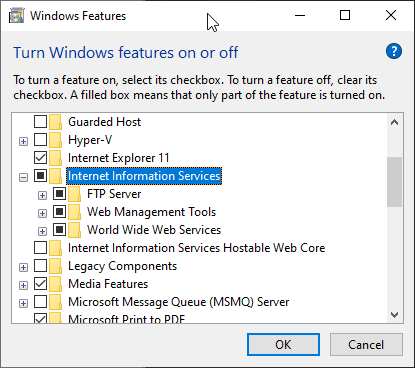

Next go to the Internet Information Services (IIS) Manager or run the cell down below

In [23]:
run('InetMgr.exe')

ERROR:root:File `"('InetMgr.exe').py"` not found.


In [17]:
import os
os.system('run.exe')

1

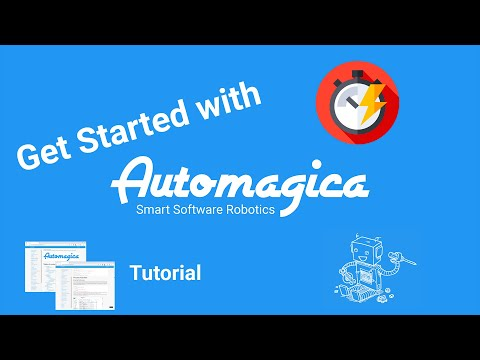

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('C5447eGY7_0')

## What do you need

* A host with Windows 10 or windows Server 2016-2019
    * MacOS and Linux are not officially supported
    
* Python 3.7 
    * Download [here](https://www.python.org/downloads/release/python-375/)

* [Automagica](https://github.com/OakwoodAI/automagica)


## Usage

Automagica consists of hundreds of activities to automate any task on a screen that can be performed by a human. These building blocks come in the form of activities and range from basic operations such as opening a file, to advanced activities such as machine learning vision.

The glue in between these activities is the open source language Python. If new to Python, we encourage everyone to go over our Basics section to learn the fundamentals which will help you automate every task with Automagica.

### Basics

#### Variables and Types

Variables are used to store information to be referenced and manipulated in an automation script. They also provide a way of labeling data with a descriptive name, so the automation script can be understood more clearly by the reader. It is helpful to think of variables as containers that hold information. Variables come in a great variety of types. Automagica supports all variable types from the Python language, but down here are some of the most prominent.

##### Strings

A string is any finite sequence of characters (i.e., letters, numerals, symbols and punctuation marks). Strings are defined either with a single quote or a double quotes.

In [14]:
automagica_string = "robots"
print(automagica_string)

robots


###### String manipulation

